In [2]:
%matplotlib inline  
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [3]:
with zipfile.ZipFile("data/BX-CSV-Dump.zip") as z:
    with z.open("BX-Book-Ratings.csv") as r, z.open("BX-Books.csv") as b, z.open("BX-Users.csv") as u:
        rating = pd.read_csv(r, sep=";", error_bad_lines=False, encoding="latin-1")
        rating.columns = ["userID", "ISBN", "bookRating"]
        
        book = pd.read_csv(b, sep=";", error_bad_lines=False, encoding="latin-1")
        book.columns = ["ISBN","bookTitle","bookAuthor","yearOfPublication","publisher","imageUrlS","imageUrlM","imageUrlL"]
        
        user = pd.read_csv(u, sep=";", error_bad_lines=False, encoding="latin-1")
        user.columns = ["userID","location","age"]

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


# Problem of this dataset

- Age that users provided is not reliable since these are online accounts with no regulation. (age that higher than 100 or even 200)
- There are many problems with regex (\") that cause columns to be shifted. This results into wrong placements of attributes

## Data Cleaning

In [4]:
# Check dataframe info() => convert to corresponding datatype
book["yearOfPublication"] = book["yearOfPublication"].astype("int64")
# Check dataframe info() => convert to corresponding datatype
user["age"] = user["age"].astype(float)
print(user.info())
print(book.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
userID      278858 non-null int64
location    278858 non-null object
age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null int64
publisher            271358 non-null object
imageUrlS            271360 non-null object
imageUrlM            271360 non-null object
imageUrlL            271360 non-null object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB
None


In [4]:
def chi_square_test(col1, col2):
    # Are Author and Age independent from each other?
    stat, p_value, dof, expected = chi2_contingency([col1, col2])
    print('Degree of Freedom=%d' % dof)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p_value))
    if p_value <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

# Question 1: Do old ppl tend to read more compare to young ppl?
## Hypothesis: 
- Yes. Young generation prefer interacting with smartphone to books.

## How:
- Merge user and rating table by userID in rating table (only keep users that have rated any books)
- Remove users in user table with Age NaN (drop)
- Count group by age
- Draw histogram

In [113]:
# Merge user and rating table by userID in rating table (left)
combined_user_rating = rating.merge(user, on='userID', how='left')
# For simplicity, we convert 0 to NaN to apply dropna()
combined_user_rating = combined_user_rating.replace(0,np.nan) 
# Remove NaN values by age and bookRating 
combined_user_rating_with_age_and_rating = combined_user_rating.dropna()

In [114]:
frequency_table_by_age = combined_user_rating_with_age_and_rating["age"].value_counts().sort_index()
ages = frequency_table_by_age.index.values
frequency = frequency_table_by_age.values

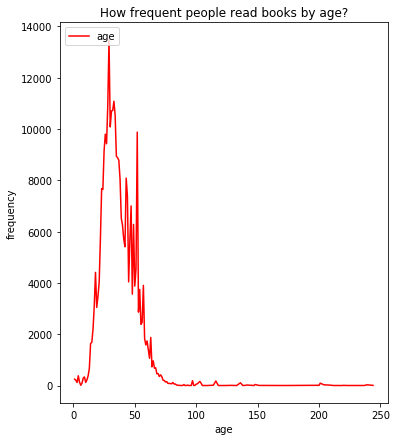

In [49]:
# Draw history of how frequency ppl read depends on age
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(132)
ax.plot(ages, frequency, color=("red"), label=("age"))
ax.set_title("How frequent people read books by age?")
ax.set_xlabel("age")
ax.set_ylabel("frequency")
ax.legend(loc='upper left')

# Question 1: Do old ppl tend to read more compare to young ppl?
## Hypothesis: 
- Yes. Young generation prefer interacting with smartphone to books.

## Results:
- Based on chi-square, age and frequency of reading are dependent on each other (good hypothesis)
- Since the graph is slightly positively skewd, we reject our hypothesis. It seems like, based on 
this dataset, young adult (between 25 and 40) read alot.
- Perhaps this dataset is collected in 2004 which is the pre-smartphone period (after 2007) :).

# Question 2: How do our top 5 authors appeal to different groups of generation?
## Hypothesis: 
- They are dependent since ppl at different generation prefer different author 
(perhaps he/she writes books with genre or content suitable with particular age)
## How:
- 123

In [6]:
# Merge book and rating table by ISBN
combined_user_rating = rating.merge(book, on='ISBN', how='left')
combined_user_book_rating = combined_user_rating.merge(user, on='userID', how='left')
removed_columns = ["imageUrlS", "imageUrlM", "imageUrlL", "publisher", 'location']
combined_user_book_rating.drop(removed_columns, axis=1, inplace=True)
combined_user_book_rating.dropna(inplace=True)

RATE_THRESHOLD = 6
combined_user_book_rating_with_condition = combined_user_book_rating.query("bookRating >= @RATE_THRESHOLD and age <= 80")

In [97]:
# Find the top 5 authors that has been receivng good ratings(>=6) from user
top5_authors = combined_user_book_rating_with_condition['bookAuthor'].value_counts().nlargest(5).index
# Query our dataframe to contain only these top 5 authors
x = combined_user_book_rating_with_condition.query("bookAuthor in @top5_authors")

In [105]:
age_groups_series = pd.cut(x["age"], bins=5, precision=0, include_lowest=False)
authors_series = x['bookAuthor'].astype('category')

assert len(age_groups_series) == len(authors_series)
contigency_age_author = pd.crosstab(index=age_groups_series, columns=authors_series,
                                    margins=True,
                                    margins_name="All")   # Include row and column totals
# contigency_age_author.columns = [a for a in top5_authors] + ["rowtotal"]
# contigency_age_author.index= [[g.left, g.right] for g in age_groups_series.unique()] + ["coltotal"]

In [106]:
contigency_age_author

bookAuthor,J. K. Rowling,James Patterson,John Grisham,Nora Roberts,Stephen King,All
age,,,,,,
"(16.0, 32.0]",107,21,6,30,44,208
"(32.0, 47.0]",703,385,467,444,1460,3459
"(47.0, 63.0]",412,565,618,925,1180,3700
"(63.0, 79.0]",100,345,295,285,358,1383
"(-0.1, 16.0]",8,51,63,53,38,213
All,1330,1367,1449,1737,3080,8963


In [109]:
# To get the proportion of counts along each row divide by the row totals
row_total = contigency_age_author["All"]
contigency_age_author.div(row_total,
                          axis=0)

bookAuthor,J. K. Rowling,James Patterson,John Grisham,Nora Roberts,Stephen King,All
age,,,,,,
"(16.0, 32.0]",0.514423,0.100962,0.028846,0.144231,0.211538,1.0
"(32.0, 47.0]",0.203238,0.111304,0.135010,0.128361,0.422087,1.0
"(47.0, 63.0]",0.111351,0.152703,0.167027,0.250000,0.318919,1.0
"(63.0, 79.0]",0.072307,0.249458,0.213304,0.206074,0.258858,1.0
"(-0.1, 16.0]",0.037559,0.239437,0.295775,0.248826,0.178404,1.0
All,0.148388,0.152516,0.161665,0.193797,0.343635,1.0


In [ ]:
'''
Question: Given author's name, what is the age range of our readers? P(age|author)
Result: 
- Interesting. It seems like young readers (16-32) prefers book written by J.K Rowling
(the author of Harry Potter =.=) but this tendency drops in older readers.
'''
# Draw graph

In [110]:
# # To get the proportion of counts along each column divide by the column totals
# column_total = contigency_age_author.loc["All"]
# contigency_age_author/column_total
'''
Question: Given author's name, what is the age range of our readers? P(age|author)
Result: 
- These results are not useful for us because the frequency 
based on readers' age are not uniform. (Refer to question 1)
'''

# Question 3: Are yearOfPublication and Age independent from each other
## Hypothesis:
- Idk really, old ppl tends to read old books? (doesn't sound plausible ryte =.=)

## How:
- Merge book and rating table by ISBN in rating table (only keep books have been rated)
- Handle Age NaN (drop)
- Drop Rating that rated by NaN age user.
- Chi-square test

In [ ]:
# Start here

# Question 4: Recommend Books using KNN with

## How
- Data includes: [userID, ISBN, bookRating, bookTitle]
- We only includes book that has at least 50 ratings (quantile > 75%) (.quantile(np.arange(0.9, 1., 0.1)))
- Create pivot with row=userID, col=ISBN

In [199]:
# Only keep users that have rated any books (scaled by 1-10)
rating_with_no_zero = rating.query("bookRating > 0")
# Merge book and rating table by ISBN
combined_book_rating = rating_with_no_zero.merge(book, on='ISBN', how='left')
drop_columns = ['yearOfPublication', 'bookAuthor', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combined_book_rating.drop(drop_columns, axis=1, inplace=True)
combined_book_rating.dropna(axis=0, subset=['bookTitle'], inplace=True)

In [200]:
rating_withCount = (combined_book_rating.
                    groupby(by=['ISBN'])['bookRating'].
                    count().
                    reset_index().
                    rename(columns={'bookRating': 'totalRatingCount'})
                   )
book_rating_withCount = combined_book_rating.merge(rating_withCount, left_on="ISBN", right_on="ISBN", how="left")

In [202]:
# Find all highest number of ratings (above 90 quantile) 
rating_withCount["totalRatingCount"].quantile(np.arange(0.9, 1.0, 0.01))

0.90     4.0
0.91     5.0
0.92     5.0
0.93     6.0
0.94     6.0
0.95     7.0
0.96     9.0
0.97    11.0
0.98    15.0
0.99    24.0
Name: totalRatingCount, dtype: float64

In [203]:
popularity_threshold = 24
rating_popular_book = book_rating_withCount.query('totalRatingCount >= @popularity_threshold')

In [204]:
user_rating_pivot = rating_popular_book.pivot(index='ISBN', columns='userID', values='bookRating').fillna(0.)
user_rating_matrix = user_rating_pivot.values

In [206]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric="cosine", algorithm='brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [207]:
books = user_rating_matrix.shape[0]
book_index = np.random.choice(books)
chosen_book = np.expand_dims(user_rating_matrix[book_index, :], axis=0)

distances, indicies = model_knn.kneighbors(chosen_book, n_neighbors=6)
for i in range(0, len(distances.flatten())):
    if i == 0:
        ISBN = user_rating_pivot.index[book_index]
        recommend_title = book_rating_withCount.query("ISBN == @ISBN")['bookTitle'].values[0]
        print('Recommendations for {}: \n'.format(recommend_title))
    else:
        ISBN = user_rating_pivot.index[indicies.flatten()[i]]
        recommend_title = book_rating_withCount.query("ISBN == @ISBN")['bookTitle'].values[0]
        distance = distances.flatten()[i]
        print('{0}, {1}, with distance of {2}'.format(i, recommend_title, distance))

Recommendations for Cry to Heaven: 

1, The Tale of the Body Thief (Vampire Chronicles (Paperback)), with distance of 0.8642365563202095
2, Feast of All Saints, with distance of 0.8650125734275367
3, The Mummy or Ramses the Damned, with distance of 0.8683354067526392
4, Belinda, with distance of 0.8698477112893227
5, Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches), with distance of 0.8837420158810253
